# CNN/LSTM

#### Imports

- This section imports all necessary libraries for data processing, model building, training, evaluation, and visualization.
- It also suppresses unnecessary warnings and configures logging to capture any issues during MIDI file processing.

In [1]:
import os
import warnings
import pretty_midi
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(filename='midi_processing.log', level=logging.WARNING)

#### Data Loading and Preprocessing

- load_midi_file function: Loads a MIDI file and returns a PrettyMIDI object, logging any errors encountered.
- extract_advanced_features function: Extracts various musical features (such as pitch, rhythm, and dynamics) from a PrettyMIDI object.
- process_data function: Processes all MIDI files in the specified directory, extracting features from each file and storing them in a DataFrame.
- Data Encoding and Splitting: Encodes the composer labels and splits the dataset into training and testing sets, followed by feature scaling and conversion to PyTorch tensors.

In [2]:
DATA_DIR = 'composers'

def load_midi_file(file_path):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            midi_data = pretty_midi.PrettyMIDI(file_path)
        return midi_data
    except Exception as e:
        logging.warning(f"Error loading {file_path}: {str(e)}")
        return None

def extract_advanced_features(pm):
    if pm is None:
        return None

    features = {}

    try:
        # Basic features
        features['num_instruments'] = len(pm.instruments)
        features['tempo'] = pm.estimate_tempo()
        features['total_duration'] = pm.get_end_time()

        # Pitch-related features
        pitches = [note.pitch for instrument in pm.instruments for note in instrument.notes]
        features['pitch_range'] = max(pitches) - min(pitches) if pitches else 0
        features['avg_pitch'] = np.mean(pitches) if pitches else 0
        features['pitch_std'] = np.std(pitches) if pitches else 0

        # Rhythm-related features
        note_durations = [note.end - note.start for instrument in pm.instruments for note in instrument.notes]
        features['avg_note_duration'] = np.mean(note_durations) if note_durations else 0
        features['note_duration_std'] = np.std(note_durations) if note_durations else 0

        # Harmony-related features
        features['unique_pitch_classes'] = len(set([pitch % 12 for pitch in pitches])) if pitches else 0

        # Dynamics
        velocities = [note.velocity for instrument in pm.instruments for note in instrument.notes]
        features['avg_velocity'] = np.mean(velocities) if velocities else 0
        features['velocity_std'] = np.std(velocities) if velocities else 0

        # Get pitch class histogram
        pitch_class_histogram = pm.get_pitch_class_histogram()
        for i, freq in enumerate(pitch_class_histogram):
            features[f'pitch_class_{i}'] = freq

        return features
    except Exception as e:
        logging.warning(f"Error extracting features: {str(e)}")
        return None

def process_data(data_dir):
    data = []
    for composer in os.listdir(data_dir):
        composer_path = os.path.join(data_dir, composer)
        if os.path.isdir(composer_path):
            for file in os.listdir(composer_path):
                if file.endswith('.mid'):
                    file_path = os.path.join(composer_path, file)
                    midi_data = load_midi_file(file_path)
                    features = extract_advanced_features(midi_data)
                    if features:
                        features['composer'] = composer
                        data.append(features)

    return pd.DataFrame(data)

df = process_data(DATA_DIR)

# Encode labels
le = LabelEncoder()
df['composer_encoded'] = le.fit_transform(df['composer'])

# Split the dataset
X = df.drop(['composer', 'composer_encoded'], axis=1).values
y = df['composer_encoded'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

#### Model Definition

- ComposerClassifier class: Defines a hybrid neural network model combining Convolutional Neural Network (CNN) layers for feature extraction and Long Short-Term Memory (LSTM) layers for capturing temporal dependencies, followed by fully connected layers for classification.

In [8]:
class ComposerClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ComposerClassifier, self).__init__()
        self.hidden_size = hidden_size

        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=256, hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)

        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout1(x)

        x = x.permute(0, 2, 1)

        _, (h_n, _) = self.lstm(x)
        x = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = self.dropout2(x)

        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

#### Data Augmentation and Dataset Definition

- augment_features function: Applies random augmentations (noise, scaling, shifting) to input features for data augmentation during training.
- ComposerDataset class: Custom Dataset class for handling data loading and augmentation for training and testing.
- Data Loaders: Creates PyTorch DataLoader objects for efficient data batching during training and evaluation.

In [4]:
# Data augmentation
def augment_features(x):
    noise = torch.randn_like(x) * 0.1
    x = x + noise
    scale = torch.randn(1) * 0.1 + 1
    x = x * scale
    shift = torch.randint(-5, 5, (1,))
    x = torch.roll(x, shifts=int(shift), dims=0)
    return x

class ComposerDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            x = augment_features(x)
        return x, self.y[idx]

train_dataset = ComposerDataset(X_train, y_train, augment=True)
test_dataset = ComposerDataset(X_test, y_test, augment=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Training and Evaluation

- train_and_evaluate function: Trains the model for a specified number of epochs, evaluates it on the test set, and saves the best-performing model based on test accuracy.
- Model Definition and Training: Defines the model, loss function, optimizer, and learning rate scheduler, and trains the model using the training data. Also plots the training loss and test accuracy over epochs.
- Final Evaluation: Loads the best model, evaluates it on the test set, and prints the final test accuracy. Additionally, plots the confusion matrix for a detailed evaluation of model performance.

Epoch [1/100], Loss: 1.1765, Test Accuracy: 0.6046, LR: 0.001000
New best model saved with accuracy: 0.6046
Epoch [2/100], Loss: 1.0280, Test Accuracy: 0.6438, LR: 0.001000
New best model saved with accuracy: 0.6438
Epoch [3/100], Loss: 0.9496, Test Accuracy: 0.6013, LR: 0.001000
Epoch [4/100], Loss: 0.9380, Test Accuracy: 0.6961, LR: 0.001000
New best model saved with accuracy: 0.6961
Epoch [5/100], Loss: 0.9103, Test Accuracy: 0.6569, LR: 0.001000
Epoch [6/100], Loss: 0.8684, Test Accuracy: 0.6601, LR: 0.001000
Epoch [7/100], Loss: 0.8693, Test Accuracy: 0.6961, LR: 0.001000
Epoch [8/100], Loss: 0.8812, Test Accuracy: 0.6961, LR: 0.001000
Epoch [9/100], Loss: 0.8194, Test Accuracy: 0.6863, LR: 0.001000
Epoch [10/100], Loss: 0.8474, Test Accuracy: 0.7320, LR: 0.001000
New best model saved with accuracy: 0.7320
Epoch [11/100], Loss: 0.7988, Test Accuracy: 0.6928, LR: 0.001000
Epoch [12/100], Loss: 0.8010, Test Accuracy: 0.7418, LR: 0.001000
New best model saved with accuracy: 0.7418
Ep

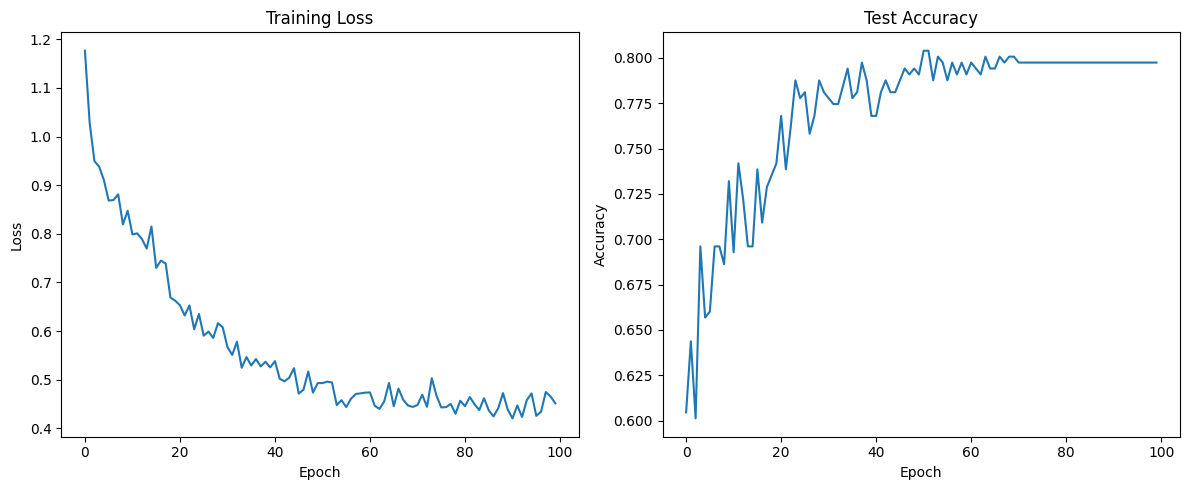

Final Test Accuracy: 0.8039


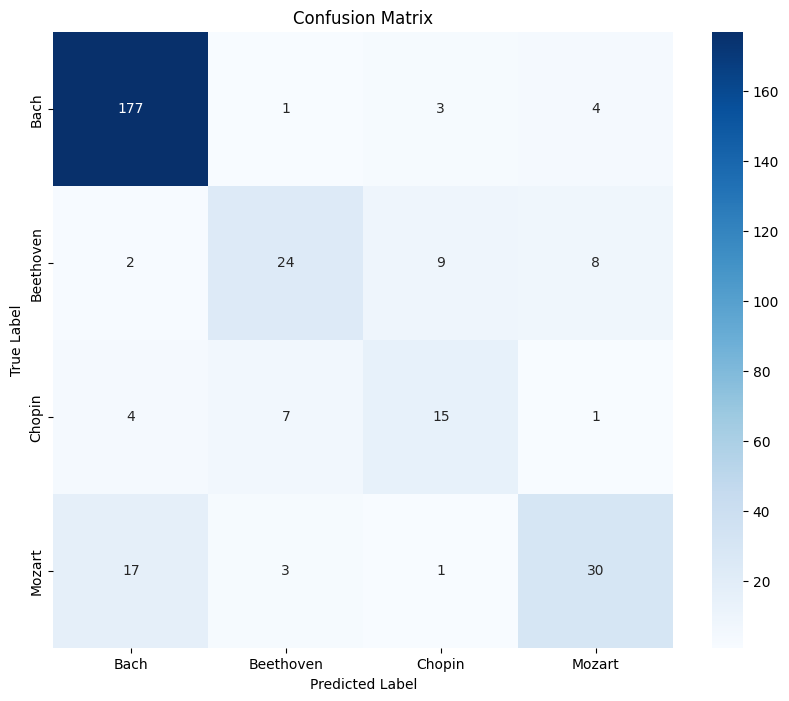

In [6]:
def train_and_evaluate(train_loader, test_loader, model, criterion, optimizer, scheduler, num_epochs=100):
    best_accuracy = 0
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        accuracy = correct / total
        test_accuracies.append(accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

        scheduler.step(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with accuracy: {best_accuracy:.4f}')

    return train_losses, test_accuracies

input_size = X_train.shape[1]
hidden_size = 256
num_classes = len(le.classes_)
model = ComposerClassifier(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

train_dataset = ComposerDataset(X_train, y_train, augment=True)
test_dataset = ComposerDataset(X_test, y_test, augment=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train and evaluate  model
train_losses, test_accuracies = train_and_evaluate(train_loader, test_loader, model, criterion, optimizer, scheduler, num_epochs=100)

# Plot training loss and test accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Final evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
all_preds = []
all_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

print(f'Final Test Accuracy: {correct / total:.4f}')

# plot confusion matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()